# Block Cipher Mode Attacks

# List of attack

| Name | Target Mode | CIA |
| :--  | :--  | :-: |
| [Bit Flipping](#BitFlipping---CBC) | CBC | Integrity |
| [Oracle Padding](#Oracle-Padding----CBC) | CBC | Confidentiality |



## BitFlipping - CBC

- [Context](#BitFlipping-Context)
- [Vulnerability](#BitFlipping-Vulnerability)
- [Repair](#BitFlipping-Repair)

### BitFlipping Context

*What does the attacker know?*

Attacker knows both plaintext and ciphertext, at least he/she knows format and/or position of specific bit to flip. (**Known-Plaintext**)

*What does the attacker does?*

Attacker produces a valid new ciphertext, with same key (but not knowning it), that corresponds to an plaintext, arbitrary chosen by attacker.



### BitFlipping Vulnerability

*What does the attacker exploit?*

CBC Cipher Mode reuse a ciphered block with plaintext to generate new ciphertext:

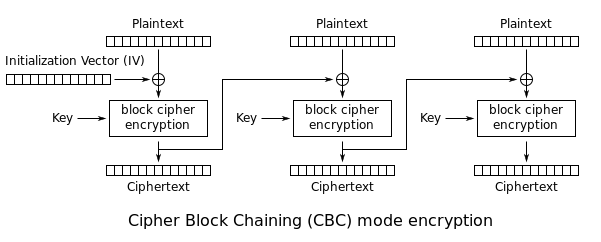

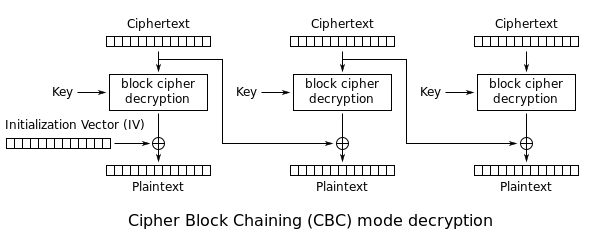

Formulas:

$$ C_i = E(P_i \oplus C_{i-1})$$

$$ P_i = D(C_i) \oplus C_{i-1}$$

Exploit:

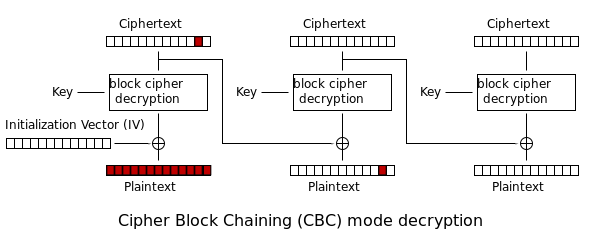

Attacker can flip a bit of cipher block to flip same bit on next plain block, nevertheless plain block corrisponding to flipped cipher block will be totally garbled and it will be useless.

Suppose to change third byte of second block:

$$P_1[2] = D(C_1)[2] \oplus C_0[2]$$

*How attacker could change ciphertext to obtain arbitrary plaintext?*

Multiply by same plaintext and chosen plaintext both members:

$$P_1[2] \oplus P_1[2] \oplus P_1^*[2] = D(C_1)[2] \oplus C_0[2] \oplus  P_1[2] \oplus P_1^*[2]$$

Using XOR properties:

$$P_1^*[2] = D(C_1)[2] \oplus C_0[2] \oplus  P_1[2] \oplus P_1^*[2]$$

Using new ciphertext is possible obtain arbitrary plaintext:

$$ C_0^*[2] = C_0[2] \oplus  P_1[2] \oplus P_1^*[2]$$

Result:

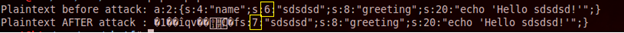

### BitFlipping Repair

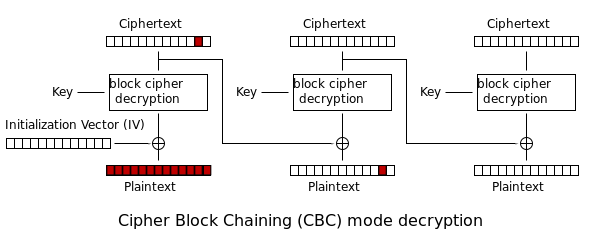

As shown previous blocks are damaged, in order to repair plaintext all previous cipher blocks and IV must change. 

In this case only IV must be change to repair plaintext:

Pre Bitflipping:

$$ P_0 = D(C_0) \oplus IV$$

Post Bitflipping

$$ P_0^* = D(C_0^*) \oplus IV$$

Let's craft an IV, in order to obtain P = P*

$$  P_0^* = D(C_0^*) \oplus IV^* = D(C_0^*) \oplus D(C_0^*) \oplus D(C_0) \oplus IV = P_0$$

Using an arbitrary IV and cipher blocks then it is possible repair plaintext:

$$ IV = D(C_0^*) \oplus D(C_0) \oplus IV $$

### BitFlip Example

In this example it is possible register cookie with own username and login by cookie.

Key and IV are set as fixed to simplify using in notebook, but it works with random values too.

In [1]:
#!/usr/bin/env python3

from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import os,sys

flag = "CCIT{REDACTED}"

key = b'0\x17\x94\x07\xe1=g(\x8e\xc12\xea$#SL' #os.urandom(16)

def handle():
    while True:
        print("1. Register")
        print("2. Login")
        print("0. Exit")
        choice = int(input("> "))
        if choice == 1:
            name = input("Insert your username: ")
            if ";" in name:
                continue
            cookie = f"usr={name};is_admin=0".encode()
            iv = b"\xd3\xe1\xf7\x0e\x2a\x17\x8e\x30\x6e\x09\x1c\x5d\x9f\x66\x76\xd9"#os.urandom(16)
            cipher = AES.new(key, AES.MODE_CBC, iv)
            encrypted = cipher.encrypt(pad(cookie, 16))
            print(f"Your login token: {iv.hex()+encrypted.hex()}")
        elif choice == 2:
            token = input("Insert your token: ")
            try:
                cookie = bytes.fromhex(token[32:])
                iv = bytes.fromhex(token[:32])
                cipher = AES.new(key, AES.MODE_CBC, iv)
                pt = unpad(cipher.decrypt(cookie),16)
                values = pt.split(b";")
                user = values[0].split(b"=")[-1].decode()
                print(f"Welcome back {user} {values[1].decode()}")
                if b"is_admin=1" in values:
                    print(f"Here is your flag {flag}")
            except e:
                print(e)
                print("Something is wrong with your token.")
        else:
            sys.exit(0)

if __name__ == "__main__":
    handle()

1. Register
2. Login
0. Exit
> 0


SystemExit: 0

/home/sage/sage/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Username can be used to easily padding for necessarly rebuild all entire cookie, though it is possible becase whe know $IV$.

In [ ]:
msg = "usr=;is_admin=0"
print(len(msg))
cookie = "d3e1f70e2a178e306e091c5d9f6676d98afb8883d84d7fd9c394951af3a90298"

If length of cookie is less than 16 bytes then it fit in only one block. In according to previosly chapter:

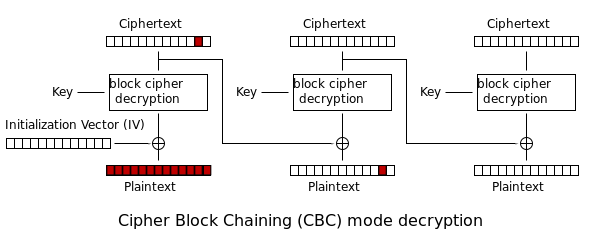

Our block's plaintext is defined as:

$$P_0[14] = D(C_0)[14] \oplus IV[14]$$

To change third byte multiply by same plaintext and chosen plaintext both members:

$$P_0[14] \oplus P_0[14] \oplus P_0^*[14] = D(C_0)[14] \oplus IV[14] \oplus  P_0[14] \oplus P_0^*[14]$$

Using XOR properties:

$$P_0^*[14] = D(C_0)[14] \oplus IV[14] \oplus  P_0[14] \oplus P_0^*[14]$$

Using new ciphertext is possible obtain arbitrary plaintext:

$$ IV^*[14] = IV[14] \oplus  P_0[14] \oplus P_0^*[14]$$


In [ ]:
from binascii import unhexlify,hexlify

cookie_byte = bytearray(unhexlify(cookie))

cookie_byte[14] = cookie_byte[14] ^ ord("0") ^ ord("1")

hexlify(cookie_byte)

Using this evil cookie, it is possible login as admin and get the flag.

### Using repairing

Considering same example but using more once block.

In [ ]:
msg = "usr=myusr;is_admin=0"
print(len(msg))
cookie = "d3e1f70e2a178e306e091c5d9f6676d929725a36768872530392d1469055ddf83d3149a1a699b8afae4aab6b3f79fad6"

In [ ]:
from binascii import unhexlify,hexlify
new_msg = "usr=myusr;is_admin=1"
cookie_byte = bytearray(unhexlify(cookie))
c = [cookie_byte[i:i+16] for i in range(0, len(cookie_byte), 16)]
m = [msg[i:i+16] for i in range(0, len(msg), 16)]
new_m = [new_msg[i:i+16] for i in range(0, len(new_msg), 16)]
print(c)
print(m)
print(new_m)
for i1 in range(len(c)-1,0,-1):
    for i2 in range(len(m[i1-1])):
        c[i1-1][i2] = c[i1-1][i2] ^ ord(m[i1-1][i2]) ^ ord(new_m[i1-1][i2])


## Oracle Padding -  CBC

This vulnerability is possible because CBC is a malleable cipher (as seen in the bitflip attack).
If we make a small change in the ciphertext, when decrypted the resulting plaintext will have that same change.

This is not a strictly crypto vulnerability, but an implementation flaw.




### Context

The target is vulnerable if:

- Uses a flawed padding method (like PKCS#5, PKCS#7, or everything else… Developers, please use HMAC)
- The implementation leaks information about valid/invalid padding

*What does the attacker know?*

Attacker can decrypt arbitrary ciphertext(**Chosen Ciphertext**), obtaining message error about valid/invalid padding (**Oracle**).

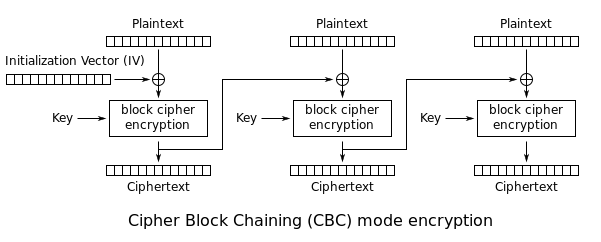

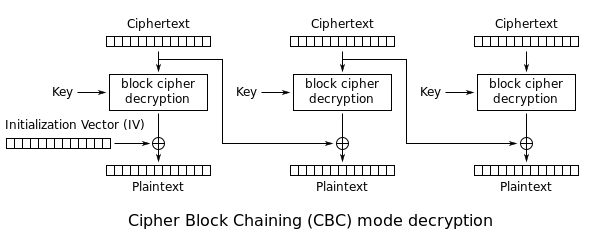

In block cipher algorithms messages are divided in $N$-size blocks, so last block can be incomplete e must be padded by a function.

#### PKCS#7

Simple function padding is PKCS#7, that fills empty last $k$ bytes with byte $0xk$. If the block is full, append another block full of padding.

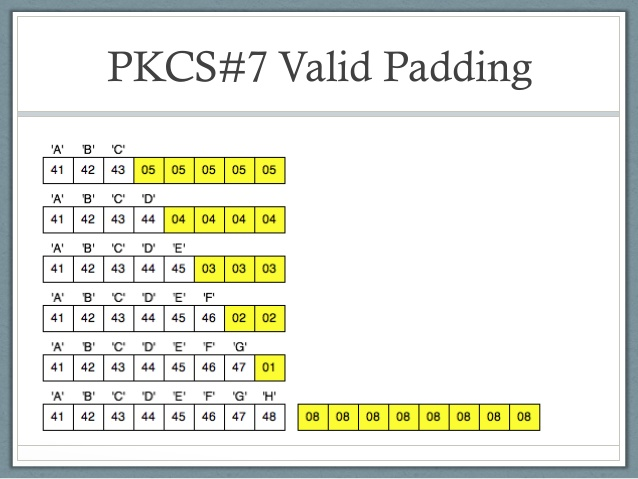

Using a known padding function, it is really easy clean plaintext after decrypt ciphertext.

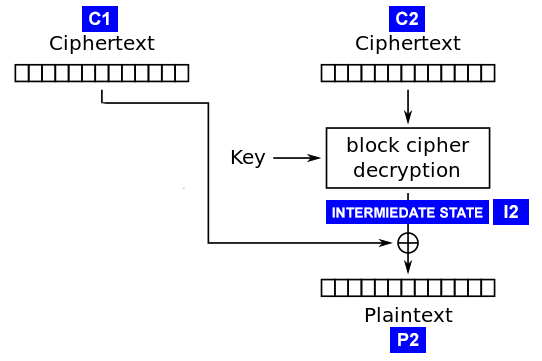

Keep in mind the CBC decryption scheme.

$$I_2 = D(C_2) $$
$$P_2 = I_2 \oplus C_1 $$

The padding will be placed at the end of $P_2$. If we bitflip the last byte in $C_1$, the last byte in $P_2$ will be flipped as well.



### Get Padding Length

In order to find last block padding length, $k$ bytes in $P_2$ need to be setted in according to PCKS#7.

So it is possible set $i$-th position byte in $C_2$ wrongly, in order to get oracle error that shows padding length.

$$ C^*_2[i] \neq C_2[i] : \forall i \leq N \text{ until get oracle error} $$ 

### Rebuild Message

Obtained $N$ padding length, in order to decrypt entire block it is possible bruteforce $N-1$-th bytes using oracle errors.

Setup last $k$ bytes to $0x(k+1)$:

$$ P^*_2[i] = (k+1) : \forall k \leq i \leq N $$

Having control on $C_1$, I can obtain result in this way:

$$ C^*_1[i] = C_1[i] \oplus 0x01$$